# TD Optim Linéaire : Planification de la production d'électricité
### Guillaume DESERMEAUX, Mastère OSE 2023
(Sujet de Sophie demassey, CMA - Mines Paris-PSL) 5 Octobre 2023
# Partie 2

In [1]:
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import  Model, GRB, multidict # Object utile pour créer des dictionnaires à partir d'une table

In [2]:
Periods, start_time, stop_time, duration, demand = multidict({
    1: ["0h", "6h", 6, 15],
    2: ["6h", "9h", 3, 30],
    3: ["9h", "15h", 6, 25],
    4: ["15h", "18h", 3, 40],
    5: ["18h", "0h", 6, 27]
})

Centrales, Ndisp, P_min, P_max, cbase, cvar, cdem, mycolor = multidict({
    'A': [ 12, 850, 2000, 1000, 2, 2000, 'r'],
    'B': [ 10, 1250, 1750, 2600, 1.3, 1000, 'g'],
    'C': [5, 1500, 4000, 3000, 3, 500, 'b']
})

Mw2Gw = lambda x : x / 1000
Gw2Mw = lambda x : x * 1000

# II.1) Coût de fonctionnement en plus
On modifie la fonction de coût en ajoutant le fonctionnement des centrales à Pmin pendant la première heure d'activation.
Dans ce nouveau cas, les variables de Puissance Y représentent la puissance des centrales après la période d'allumage.
Dans ce cas la contrainte de demande change aussi

In [3]:
# Create a new model
m = gp.Model()

## Create variables
# Total thermal power of the plants A, B, C for every period
Y = m.addVars(Periods, Centrales, 
              lb = 0,
              #ub = [ Mw2Gw(P_max[c])*Ndisp[c] for c, p in product(Centrales, Periods) ],
              name = 'Production',
              vtype = GRB.CONTINUOUS)

X = m.addVars(Periods, Centrales,
              lb = 0,
              ub = [ (Ndisp[c] for p in Periods for c in Centrales ) ],
              name = 'Number_plants', 
              vtype = GRB.INTEGER)

## Set objective function
total_cost = sum( [ duration[p]*(X[(p, c)]*(cbase[c] - cvar[c]*P_min[c]) + cvar[c]*Gw2Mw(Y[(p, c)]))
                        for p in Periods for c in Centrales ] )
obj = m.setObjective(total_cost, gp.GRB.MINIMIZE)

## Add constraints
# Demand on the network
c_demand = m.addConstrs( ( Y.sum(p, '*') >= demand[p] 
                                   for p in Periods ), name = "Demand" ) 
# Power constraints on the plants
c_p_min = m.addConstrs( (  Y[(p, c)] >= Mw2Gw(P_min[c])*X[(p, c)]
                                  for c in Centrales for p in Periods ), name = "Pmin" )
c_p_max = m.addConstrs( ( Y[(p, c)] <= Mw2Gw(P_max[c])*X[(p, c)] 
                                  for c in Centrales for p in Periods ), name = "Pmax" )
m.update()

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [4]:
m.write("PowerOptim0.lp")

In [5]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0x1af676bf
Variable types: 15 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+00]
  Objective range  [2e+03, 2e+04]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+01, 4e+01]
Found heuristic solution: objective 1379850.0000
Presolve removed 28 rows and 24 columns
Presolve time: 0.00s
Presolved: 7 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 1039800.0000
Variable types: 3 continuous, 3 integer (0 binary)

Root relaxation: objective 9.780000e+05, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

{'obj': 978900.0, 'lb': 978900.0, 'gap': 0.0, 'time': 0.01399993896484375}
plan to activate units: {'A': [12, 12, 12, 12, 12], 'B': [2, 10, 8, 10, 9], 'C': [0, 0, 0, 0, 0]}


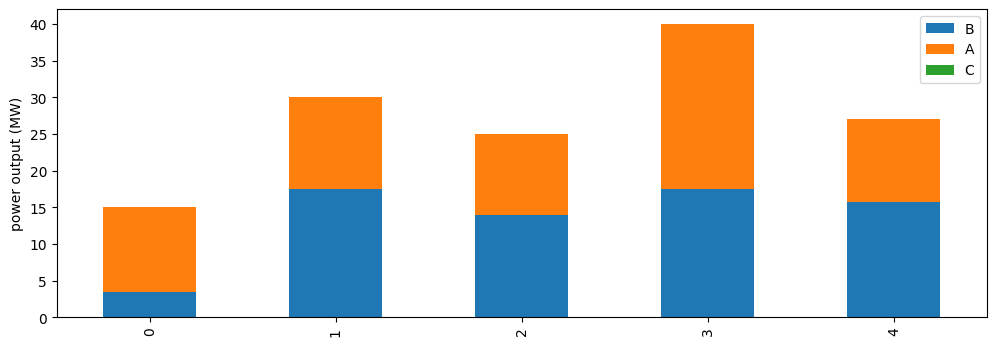

In [6]:
# solution characteristics
result = {'obj': m.objVal, 'lb': m.objBound,  'gap': m.mipGap, 'time': m.runtime}
print(result)

# optimal plan
ndict = {t: [int(v.x) for v in X.select('*', t)] for t in Centrales}
print(f"plan to activate units: {ndict}")

orderedgen = sorted(Centrales, key=lambda x: cvar[x])
pdict = {t: [v.x for v in Y.select('*', t)] for t in orderedgen}
powerdf = pd.DataFrame(data=pdict)

fig, axs = plt.subplots(figsize=(12, 4))
powerdf.plot.bar(stacked=True, ax=axs)
axs.set_ylabel("power output (MW)")
fig.savefig("powergen_2.1.png")
plt.show()

## II.2) Cout de démarrage 

In [8]:
# Create a new model
m2 = gp.Model()

## Create variables
# Total thermal power of the plants A, B, C for every period
Y = m2.addVars(Periods, Centrales, 
              lb = 0,
              #ub = [ Mw2Gw(P_max[c])*Ndisp[c] for c, p in product(Centrales, Periods) ],
              name = 'Production',
              vtype = GRB.CONTINUOUS)

X = m2.addVars(Periods, Centrales,
              lb = 0,
              ub = [ (Ndisp[c] for p in Periods for c in Centrales ) ],
              name = 'Number_plants', 
              vtype = GRB.INTEGER)

## Set objective function
total_cost = gp.quicksum( [ duration[p]*(X[(p, c)]*(cbase[c] - cvar[c]*P_min[c]) + cvar[c]*Gw2Mw(Y[(p, c)])) 
                    for p in Periods for c in Centrales ] ) 
total_cost += gp.quicksum( [ cbase[c]*(X[(1, c)] + X[(p, c)] - X[(p-1, c)])
                    for p in Periods[1:] for c in Centrales ] )
obj = m2.setObjective(total_cost, gp.GRB.MINIMIZE)

## Add constraints
# Demand on the network
c_demand = m2.addConstrs( ( Y.sum(p, '*') >= demand[p] 
                                   for p in Periods ), name = "Demand" ) 
# Power constraints on the plants
c_p_min = m2.addConstrs( (  Y[(p, c)] >= Mw2Gw(P_min[c])*X[(p, c)]
                                  for c in Centrales for p in Periods ), name = "Pmin" )
c_p_max = m2.addConstrs( ( Y[(p, c)] <= Mw2Gw(P_max[c])*X[(p, c)] 
                                  for c in Centrales for p in Periods ), name = "Pmax" )
m2.update()

In [9]:
m2.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0x64bef374
Variable types: 15 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+00]
  Objective range  [1e+03, 2e+04]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+01, 4e+01]
Found heuristic solution: objective 1465850.0000
Presolve removed 28 rows and 24 columns
Presolve time: 0.01s
Presolved: 7 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 1119800.0000
Variable types: 3 continuous, 3 integer (0 binary)

Root relaxation: objective 1.045286e+06, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N